## Time Series Analysis of Daily Temperature for Berlin- Tempelhof

### Part 3: The ARIMA model

####  Import libraries

In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

# Set figure size to (16,8)
plt.rcParams['figure.figsize'] = (16,8)
# Set some easthetic
sns.set()
from statsmodels.api import OLS, add_constant, qqplot
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import TimeSeriesSplit, cross_val_score


plt.rcParams['font.size'] = '14'

**The Dataset** 

A full dataset between 1950 - 09-2022 containing trend, seasonal features and remainder from the previous part of the analyses 

In [428]:
# df = pd.read_csv('../data/temp_train_remainder.csv', parse_dates=True, index_col=0)
df = pd.read_csv('../data/temp_subs_full.csv', parse_dates=True, index_col=0)

In [430]:
df.head(2)

,av_temp,timestep,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder
DATE,,,,,,,,,,,,,,,,
1950-01-01,-3.5,0,8.844459,0,0,0,0,0,0,0,0,0,0,0,-0.488925,-3.011075
1950-01-02,1.0,1,8.844538,0,0,0,0,0,0,0,0,0,0,0,-0.488852,1.488852


In [396]:
df["remainder"].std(), df["av_temp"].std()

(3.919744779466226, 7.895796734351724)

### Model Selection
** Inspecting the remainder and decide on how many / which lags to include **

####  Autocorrelation and Partial Autocorrelation 
*** An exponential and slow decay in the ACF, and a drop in PACF-Plot shows after a certain lag, indicate that the data is best modelled by an AR(p) process as oppose to a sharp drop in the ACF plot at lag q which indicates an MA(q) process. 

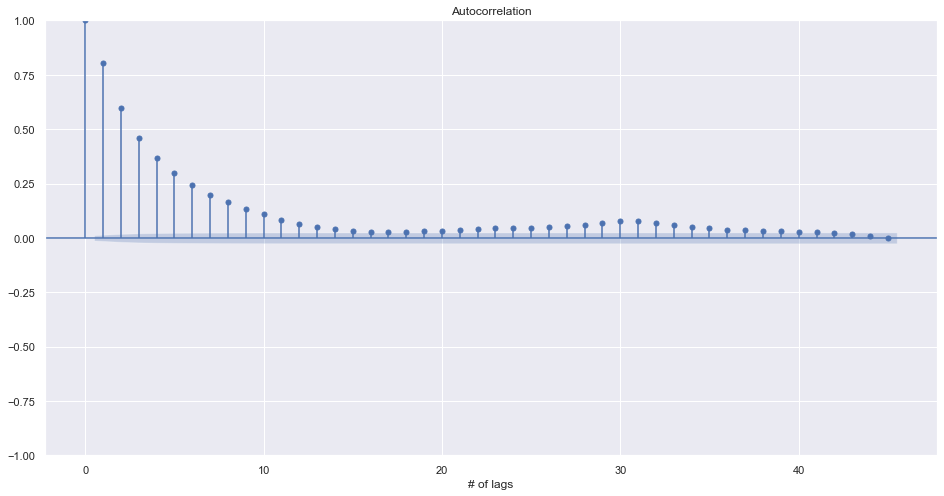

In [398]:
from statsmodels.graphics.tsaplots import plot_acf
plot = plot_acf(df['remainder'])
plt.xlabel('# of lags');

***  Looking at the Partial Autocorrelation below, we will choose all lags until the first sharp drop in values, for the AR.

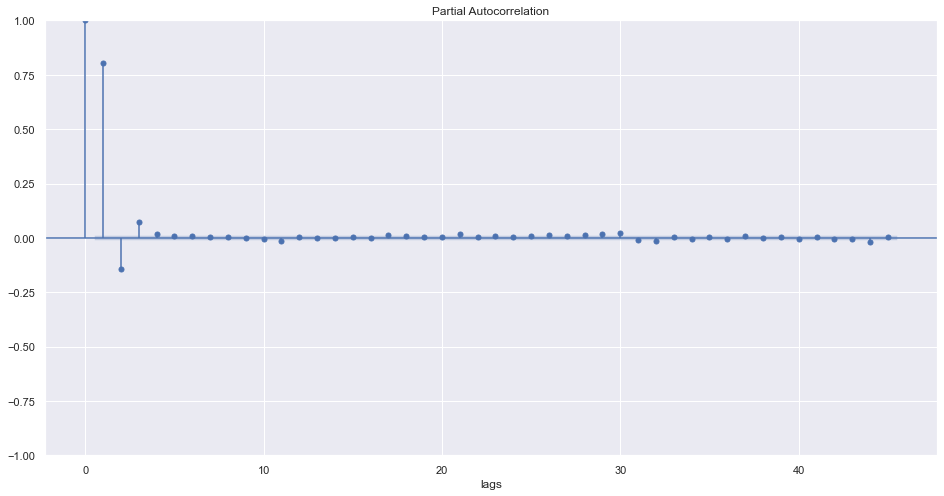

In [399]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['remainder'], method='ywm')
plt.xlabel('lags');

####  Statsmodels ar_select_order can also help in selecting lags

In [402]:
selected_order = ar_select_order(df['remainder'], maxlag = 15)
print(f"The lag we need to include are {selected_order.ar_lags}")

The lag we need to include are [1, 2, 3]


C:\Users\ndafu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ndafu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


#### Train autoregression model with `statsmodels`

In [403]:
ar_model = AutoReg(endog= df['remainder'], lags = 3).fit()

C:\Users\ndafu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [404]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                26571
Model:                     AutoReg(3)   Log Likelihood              -59860.577
Method:               Conditional MLE   S.D. of innovations              2.303
Date:                Thu, 03 Nov 2022   AIC                         119731.155
Time:                        23:26:10   BIC                         119772.092
Sample:                    01-04-1950   HQIC                        119744.366
                         - 09-30-2022                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0002      0.014     -0.017      0.987      -0.028       0.027
remainder.L1     0.9276      0.006    151.614      0.000       0.916       0.940
remainder.L2    -0.2092      0.008    -25.334      0.000      -0.225      -0.193
remainder.L3     0.0741      0.006     12.118      0.000       0.062       0.086
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2799           -0.0000j            1.2799           -0.0000
AR.2            0.7707           -3.1535j            3.2463           -0.2119
AR.3            0.7707           +3.1535j            3.2463            0.2119
-----------------------------------------------------------------------------
"""

In [405]:
df['ar_prediction'] = ar_model.predict()
df.head()

,av_temp,timestep,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,ar_prediction
DATE,,,,,,,,,,,,,,,,,
1950-01-01,-3.5,0,8.844459,0,0,0,0,0,0,0,0,0,0,0,-0.488925,-3.011075,NaN
1950-01-02,1.0,1,8.844538,0,0,0,0,0,0,0,0,0,0,0,-0.488852,1.488852,NaN
1950-01-03,2.9,2,8.844617,0,0,0,0,0,0,0,0,0,0,0,-0.488780,3.388780,NaN
1950-01-04,-0.1,3,8.844695,0,0,0,0,0,0,0,0,0,0,0,-0.488707,0.388707,2.608517
1950-01-05,-3.0,4,8.844774,0,0,0,0,0,0,0,0,0,0,0,-0.488634,-2.511366,-0.238118


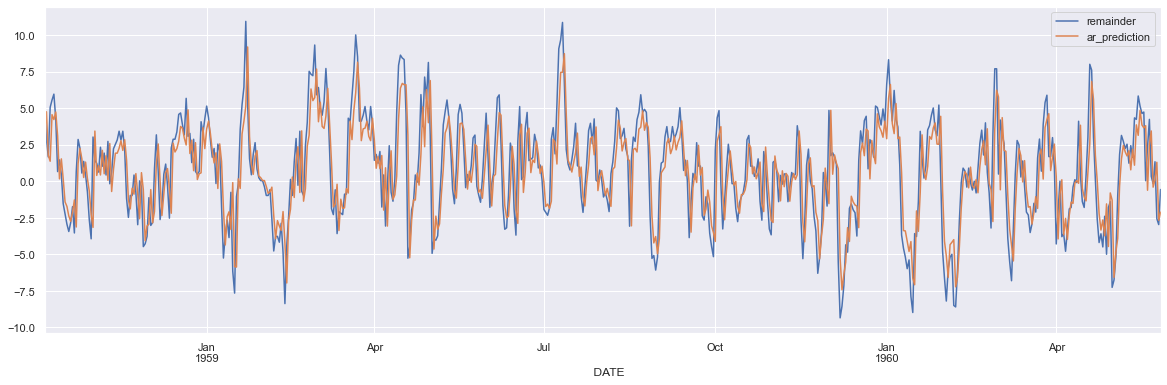

In [406]:
df[['remainder', 'ar_prediction']][3200:3800].plot(figsize = (20, 6));

####  Combine into a complete model with trend + seasonality and AR component for the remainder

In [407]:
df.dropna(inplace = True)

####  Full AR Model (Linear Regression) with lag features and trend with seasonality

In [408]:
df['full_pred_ar'] = df['trend_seasonal'] + df['ar_prediction']
df.head()

,av_temp,timestep,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,ar_prediction,full_pred_ar
DATE,,,,,,,,,,,,,,,,,,
1950-01-04,-0.1,3,8.844695,0,0,0,0,0,0,0,0,0,0,0,-0.488707,0.388707,2.608517,2.119810
1950-01-05,-3.0,4,8.844774,0,0,0,0,0,0,0,0,0,0,0,-0.488634,-2.511366,-0.238118,-0.726752
1950-01-06,2.3,5,8.844853,0,0,0,0,0,0,0,0,0,0,0,-0.488561,2.788561,-2.159832,-2.648394
1950-01-07,5.2,6,8.844931,0,0,0,0,0,0,0,0,0,0,0,-0.488489,5.688489,3.140537,2.652048
1950-01-08,7.0,7,8.845010,0,0,0,0,0,0,0,0,0,0,0,-0.488416,7.488416,4.506908,4.018492


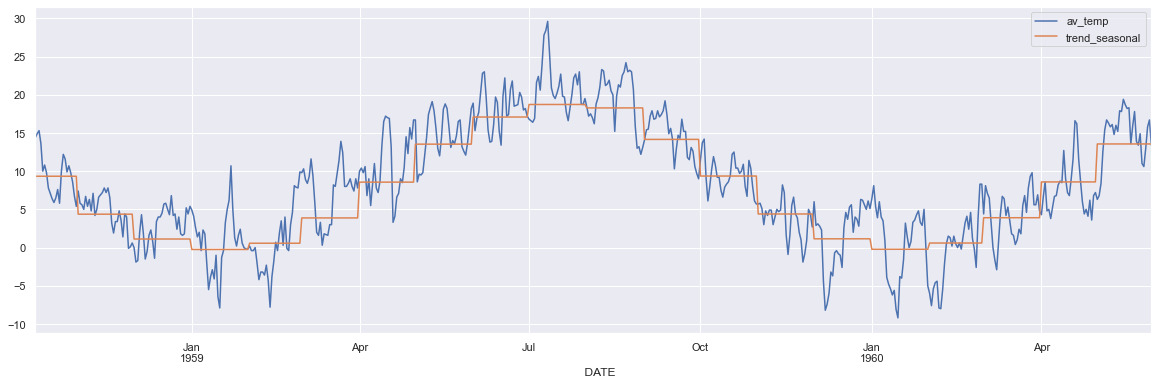

In [409]:
df[['av_temp', 'trend_seasonal']][3200:3800].plot(figsize = (20, 6));

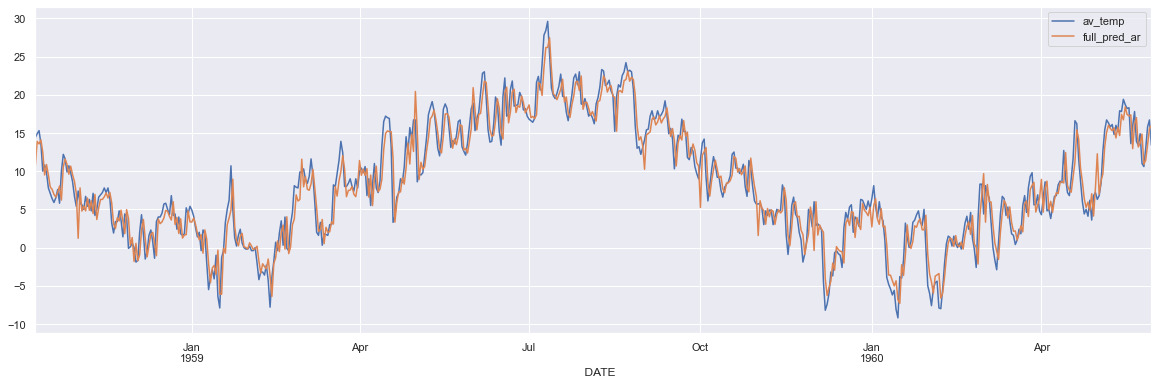

In [410]:
df[['av_temp', 'full_pred_ar']][3200:3800].plot(figsize = (20, 6));

## ARIMA with `statsmodels`

In [411]:
from statsmodels.tsa.arima.model import ARIMA

In [412]:
arima = ARIMA(endog= df['remainder'], order = (3,1,0)).fit()

C:\Users\ndafu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ndafu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ndafu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [413]:
df['arima_prediction'] = arima.predict()
df.head()

,av_temp,timestep,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,ar_prediction,full_pred_ar,arima_prediction
DATE,,,,,,,,,,,,,,,,,,,
1950-01-04,-0.1,3,8.844695,0,0,0,0,0,0,0,0,0,0,0,-0.488707,0.388707,2.608517,2.119810,0.000000
1950-01-05,-3.0,4,8.844774,0,0,0,0,0,0,0,0,0,0,0,-0.488634,-2.511366,-0.238118,-0.726752,0.388707
1950-01-06,2.3,5,8.844853,0,0,0,0,0,0,0,0,0,0,0,-0.488561,2.788561,-2.159832,-2.648394,-2.595905
1950-01-07,5.2,6,8.844931,0,0,0,0,0,0,0,0,0,0,0,-0.488489,5.688489,3.140537,2.652048,3.495479
1950-01-08,7.0,7,8.845010,0,0,0,0,0,0,0,0,0,0,0,-0.488416,7.488416,4.506908,4.018492,5.101125


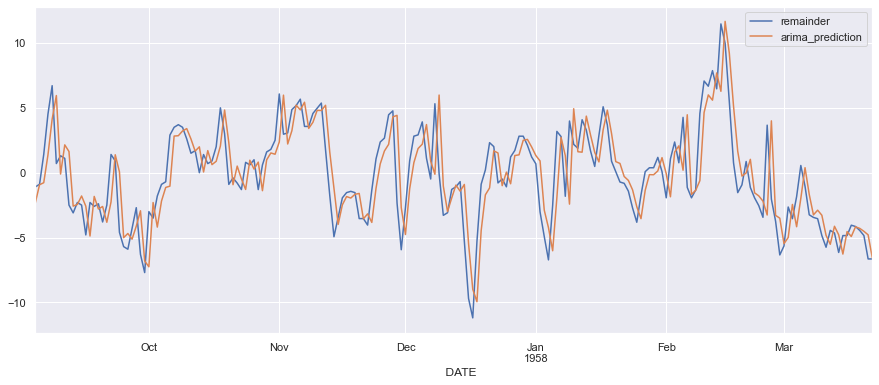

In [414]:
df[['remainder', 'arima_prediction']][2800:3000].plot(figsize = (15, 6));

### Compare models with evaluation metrics

In [415]:
from sklearn.metrics import mean_absolute_error

In [416]:
ar_error = round(mean_absolute_error(df['remainder'], df['ar_prediction']),2)
arima_error = round(mean_absolute_error(df['remainder'], df['arima_prediction']),2)

In [420]:
f'Mean absolute error for Auto Regression: {ar_error}, was a as expected better than that of ARIMA {arima_error}' 

'Mean absolute error for Auto Regression: 1.79, was a as expected better than that of ARIMA 1.85'

In [421]:
### For the full temp
df['full_pred_arima'] = df['trend_seasonal']+ df['arima_prediction']

In [422]:
base_model_error = round(mean_absolute_error(df['av_temp'], df['trend_seasonal']), 3)
ar_error = round(mean_absolute_error(df['av_temp'], df['full_pred_ar']), 3)
arima_error = round(mean_absolute_error(df['av_temp'], df['full_pred_arima']), 3)

In [423]:
f'Mean absolute error for the base model {base_model_error}, the  Auto Regression: {ar_error} and  ARIMA {arima_error}'

'Mean absolute error for the base model 3.121, the  Auto Regression: 1.794 and  ARIMA 1.85'

### **Is the remainder stationary?**
Augmented Dickey-Fuller Test -a stationarity test for time series

In [ ]:
import statsmodels
from statsmodels.tsa import stattools

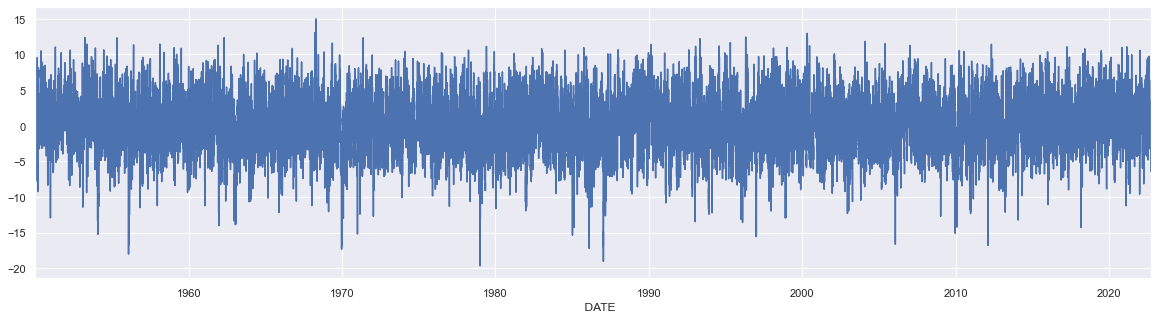

In [424]:
df.remainder.plot(figsize = (20, 5));

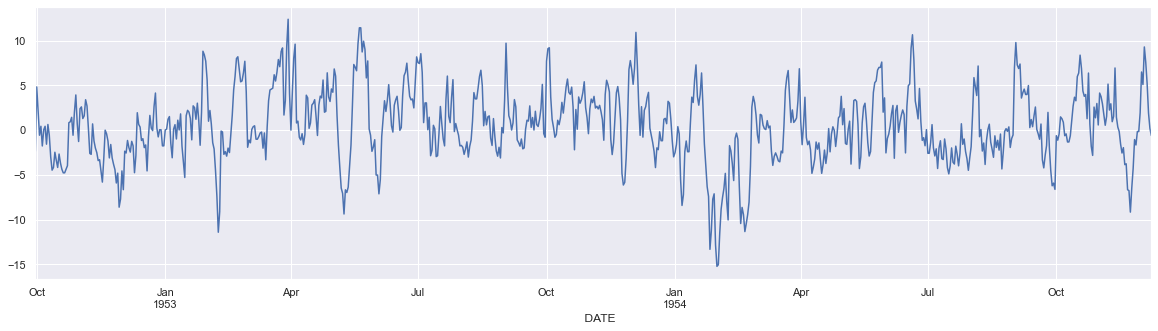

In [425]:
df[1000:1800].remainder.plot(figsize = (20, 5));

In [426]:
def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = \
            statsmodels.tsa.stattools.adfuller(data)
    
    print(f"""   
            adf: {round(adf_stats,2)}
            p: {p} 
            used lag: {used_lag} 
            number of observations: {n_obs}
            {round(levels['1%'],2)} (p=0.01; CI=99%) 
            {round(levels['5%'],2)} (p=0.05; CI=95%)
            {round(levels['10%'],2)} (p=0.1 CI=90%) 
            information criterion (AIC): {information_criterion}
            """)

In [427]:
print_adf(df.remainder)
## looking at the p value below, we can with 99% confidence reliably reject the null hypothesis
## which states that the data is not stationary and can assume that the data has stationarity property

   
            adf: -23.35
            p: 0.0 
            used lag: 31 
            number of observations: 26536
            -3.43 (p=0.01; CI=99%) 
            -2.86 (p=0.05; CI=95%)
            -2.57 (p=0.1 CI=90%) 
            information criterion (AIC): 119452.97467907442
            
